# Modeling

The full extent of the modeling process is contained in this notebook. In order to achieve the goal of producing a model that can predict joe sessions, I perform tasks such as data wrangling, feature-engineering, and thoroughly test two different classification algorithms. I also employ techniques to manage the extreme class imbalance, a feature of the data that requires me to evaluate the model using multiple metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.feature_selection import RFE, RFECV, chi2, SelectKBest, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score,\
precision_score, roc_auc_score, roc_curve, classification_report, precision_recall_curve

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IM_Pipeline

import joblib
from utils import make_confusion_matrix


/Users/georgemcintire/projects/job_assignments/toptal/George-McIntire-2/assignment_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/georgemcintire/projects/job_assignments/toptal/George-McIntire-2/assignment_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/georgemcintire/projects/job

Load in data

In [38]:
df = pd.read_csv("../data/new_data.csv", index_col=[0])
sites = pd.read_csv("../data/sites_tf.csv", index_col=[0])
df.head()

,browser,os,gender,location,sites,time,date,target,software_language,software_country,weekday
0,Chrome,Windows 8,m,Canada/Toronto,"[{'site': 'lenta.ru', 'length': 296}, {'site':...",03:57:00,2016-08-14,0,de,DE,0
1,Chrome,Windows 10,f,Netherlands/Amsterdam,"[{'site': 'windowsupdate.com', 'length': 56}, ...",13:52:00,2016-05-31,0,pt,PT,1
2,Chrome,Windows 10,m,Brazil/Rio de Janeiro,"[{'site': 'slack.com', 'length': 158}, {'site'...",17:40:00,2019-04-15,0,bg,BG,1
3,Internet Explorer,Ubuntu,f,New Zealand/Auckland,"[{'site': 'amazon.com', 'length': 168}, {'site...",20:23:00,2018-03-25,0,en,US,0
4,Firefox,Debian,f,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 43}, {'site': 'm...",01:10:00,2018-09-08,0,ro,RO,0


In [39]:
df["date"] = pd.to_datetime(df.date)

In [40]:
df = df.sort_values(by = "date")

In [41]:
df.head()

,browser,os,gender,location,sites,time,date,target,software_language,software_country,weekday
32339,Chrome,Windows 8,m,Spain/Madrid,"[{'site': 'youtube.com', 'length': 72}, {'site...",23:18:00,2016-01-14,0,es,MX,1
19405,Firefox,Debian,f,New Zealand/Auckland,"[{'site': 'nflxso.net', 'length': 54}, {'site'...",22:27:00,2016-01-14,0,pt,PT,1
76158,Chrome,Windows 7,m,Malaysia/Kuala Lumpur,"[{'site': 'vimeo.com', 'length': 219}, {'site'...",21:52:00,2016-01-14,0,fr,FR,1
43230,Chrome,Ubuntu,m,Australia/Sydney,"[{'site': 'twitter.com', 'length': 194}, {'sit...",21:25:00,2016-01-14,0,de,DE,1
146883,Chrome,Windows 8,f,Russia/Moscow,"[{'site': 'googleadservices.com', 'length': 16...",22:20:00,2016-01-14,0,bg,BG,1


In [43]:
from sklearn.model_selection import TimeSeriesSplit

In [44]:
# TimeSeriesSplit()

In [45]:
df.head()

,browser,os,gender,location,sites,time,date,target,software_language,software_country,weekday
32339,Chrome,Windows 8,m,Spain/Madrid,"[{'site': 'youtube.com', 'length': 72}, {'site...",23:18:00,2016-01-14,0,es,MX,1
19405,Firefox,Debian,f,New Zealand/Auckland,"[{'site': 'nflxso.net', 'length': 54}, {'site'...",22:27:00,2016-01-14,0,pt,PT,1
76158,Chrome,Windows 7,m,Malaysia/Kuala Lumpur,"[{'site': 'vimeo.com', 'length': 219}, {'site'...",21:52:00,2016-01-14,0,fr,FR,1
43230,Chrome,Ubuntu,m,Australia/Sydney,"[{'site': 'twitter.com', 'length': 194}, {'sit...",21:25:00,2016-01-14,0,de,DE,1
146883,Chrome,Windows 8,f,Russia/Moscow,"[{'site': 'googleadservices.com', 'length': 16...",22:20:00,2016-01-14,0,bg,BG,1


**Dropping Features**

In the EDA notebook we saw that `time`, `date`, `avg_length`, and `weekday` contained no useful signals in predicting the target variable. And since we have `country`, we don't need `city`.

In [14]:
# drops = ["time", "date", "avg_length", "weekday", 'city']
# df.drop(drops, axis = 1, inplace=True)

In [46]:
drops = ["date", "sites", "weekday", 'location']
df.drop(drops, axis = 1, inplace=True)

In [47]:
df.head()

,browser,os,gender,time,target,software_language,software_country
32339,Chrome,Windows 8,m,23:18:00,0,es,MX
19405,Firefox,Debian,f,22:27:00,0,pt,PT
76158,Chrome,Windows 7,m,21:52:00,0,fr,FR
43230,Chrome,Ubuntu,m,21:25:00,0,de,DE
146883,Chrome,Windows 8,f,22:20:00,0,bg,BG


In [48]:
df["hour"] = df.time.apply(lambda x:x[:2])

**Fixing `software_country`**

In the EDA notebook, we saw that only one `software_country` value (RU) appeared in a joe session. Therefore I think it's best to transform this feature to a binary varialble — "RU" vs "Other".

In [49]:
#Create new binary variable representing RU software usage
df["russia_software"] = np.where(df.software_country=='RU', "RU", "Other")

#drop software_country
df.drop('software_country', axis = 1, inplace=True)
df.drop('software_language', axis = 1, inplace=True)

In [50]:
df.head()

,browser,os,gender,time,target,hour,russia_software
32339,Chrome,Windows 8,m,23:18:00,0,23,Other
19405,Firefox,Debian,f,22:27:00,0,22,Other
76158,Chrome,Windows 7,m,21:52:00,0,21,Other
43230,Chrome,Ubuntu,m,21:25:00,0,21,Other
146883,Chrome,Windows 8,f,22:20:00,0,22,Other


Let's combine the `sites` and `df` datasets together. But first I'd like to clean up the `sites` columns

In [51]:
sites.columns = sites.columns.str.replace(".", "_")


/var/folders/lj/w4hy005d5vx9qy3lrwz0xdl80000gn/T/ipykernel_44887/56842448.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sites.columns = sites.columns.str.replace(".", "_")


Append "site_" to start of `sites` column names

In [52]:
sites.columns = 'site_' + sites.columns

In [53]:
sites.head()

,site_10hui_es,site_123inkt_nl,site_17995api_com,site_17k_com,site_19thnews_org,site_1cv8update_com,site_1frozenthrone1_com,site_1geki_jp,site_1lib_in,site_21clradio_com,...,site_zooniverse_org,site_zooplus_nl,site_zooqle_com,site_zoup_com,site_zqlx_com,site_zradio_org,site_zscalergov_net,site_zubuchygri_com,site_zuuks_com,site_zwcloud_wang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Concatenate the `df` and `sites` dataframes

In [54]:
df = pd.concat([df, sites], axis = 1)
df.head()

,browser,os,gender,time,target,hour,russia_software,site_10hui_es,site_123inkt_nl,site_17995api_com,...,site_zooniverse_org,site_zooplus_nl,site_zooqle_com,site_zoup_com,site_zqlx_com,site_zradio_org,site_zscalergov_net,site_zubuchygri_com,site_zuuks_com,site_zwcloud_wang
32339,Chrome,Windows 8,m,23:18:00,0,23,Other,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19405,Firefox,Debian,f,22:27:00,0,22,Other,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76158,Chrome,Windows 7,m,21:52:00,0,21,Other,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43230,Chrome,Ubuntu,m,21:25:00,0,21,Other,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146883,Chrome,Windows 8,f,22:20:00,0,22,Other,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Separate the `target` variable from the features

In [56]:
160/1.33

120.30075187969925

In [63]:
N = 3*(df.shape[0]//4)

In [67]:
df.drop("time", axis = 1, inplace=True)

In [68]:
X = df.drop("target", axis = 1)
y = df.target

In [69]:
X_train = X.iloc[:N]
X_valid = X.iloc[N:]
y_train = y.iloc[:N]
y_valid = y.iloc[N:]

In [70]:
X_train.head()

,browser,os,gender,hour,russia_software,site_10hui_es,site_123inkt_nl,site_17995api_com,site_17k_com,site_19thnews_org,...,site_zooniverse_org,site_zooplus_nl,site_zooqle_com,site_zoup_com,site_zqlx_com,site_zradio_org,site_zscalergov_net,site_zubuchygri_com,site_zuuks_com,site_zwcloud_wang
32339,Chrome,Windows 8,m,23,Other,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19405,Firefox,Debian,f,22,Other,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76158,Chrome,Windows 7,m,21,Other,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43230,Chrome,Ubuntu,m,21,Other,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146883,Chrome,Windows 8,f,22,Other,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create training and validation datasets

In [71]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=1, stratify=y)
# X_train.head()

## Feature engineering Pipeline

There are two components to the feature engineering pipeline:
- One hot encoding for the discrete variables.
- Normalization using standardization for the continous variables.

**Standardization**

In [77]:
# X

In [72]:
#collect all columns
cols = X.columns


Standardization will be applied to columns representing length of visits to sites.

In [73]:
#collect sites columns
site_cols = X.columns[X.columns.str.startswith("site_")].tolist()

#create boolean mask for features that are in site_cols
site_mask = cols.isin(site_cols).tolist()


In [74]:
#Intialize pipeline object that will be used to scale numerical data
pipeline_scale = Pipeline([("scale", StandardScaler())])

#Create a tuple that has three values, 
# 1. Step name
# 2. The pipeline
# 3. column mask which tells sklearn which columns to transform which not to
column_transform_scale_step = ("numerical", pipeline_scale, site_mask)

Repeat similar process for categorical data.

In [75]:
df.head()

,browser,os,gender,target,hour,russia_software,site_10hui_es,site_123inkt_nl,site_17995api_com,site_17k_com,...,site_zooniverse_org,site_zooplus_nl,site_zooqle_com,site_zoup_com,site_zqlx_com,site_zradio_org,site_zscalergov_net,site_zubuchygri_com,site_zuuks_com,site_zwcloud_wang
32339,Chrome,Windows 8,m,0,23,Other,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19405,Firefox,Debian,f,0,22,Other,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76158,Chrome,Windows 7,m,0,21,Other,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43230,Chrome,Ubuntu,m,0,21,Other,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146883,Chrome,Windows 8,f,0,22,Other,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
cat_cols = ['browser', 'os', 'gender', 'hour', "russia_software"]
cat_cols_mask= cols.isin(cat_cols)

pipeline_ohe = Pipeline([("ohe", OneHotEncoder(categories='auto', 
                                               handle_unknown='error', 
                                               sparse=False, drop="first"))])
column_transform_ohe_step = ("cat", pipeline_ohe, cat_cols_mask)

Combine the two steps into one pipeline

In [79]:
#Organize the pipelines in a list

transformer_steps = [column_transform_ohe_step, column_transform_scale_step]

#Intialize the ColumnTransformer object with the transformer steps

feat_eng_pipe = ColumnTransformer(transformers=transformer_steps)

Fit the pipeline on the training data, followed by transforming both the training and validation datasets.

In [80]:
#Fit transform the train dataset
X_train = feat_eng_pipe.fit_transform(X_train)

#Transform the testing dataset with the rules learned from the training dataset 
X_valid = feat_eng_pipe.transform(X_valid)



The shape of the pre-processed training data.

In [81]:
X_train.shape

(120000, 3219)

Save pipeline transformer object.

In [19]:
joblib.dump(feat_eng_pipe, "../model/feature_engineer_pipeline.pkl")

['../model/feature_engineer_pipeline.pkl']

Pipeline leaves us with 1049 features.

Now let's convert the transformed data back into pandas dataframes.

In [82]:
#Access pipeline data to so we can name the one hot encoded columns
cat_col_names = feat_eng_pipe.named_transformers_["cat"]["ohe"].get_feature_names(cat_cols).tolist()
    
#Create list of column names
column_names = cat_col_names + site_cols

X_train = pd.DataFrame(data=X_train, columns=column_names)
X_valid = pd.DataFrame(data=X_valid, columns=column_names)
X_train.head()

,browser_Firefox,browser_Internet Explorer,browser_Safari,os_MacOS,os_Ubuntu,os_Windows 10,os_Windows 7,os_Windows 8,gender_m,hour_01,...,site_zooniverse_org,site_zooplus_nl,site_zooqle_com,site_zoup_com,site_zqlx_com,site_zradio_org,site_zscalergov_net,site_zubuchygri_com,site_zuuks_com,site_zwcloud_wang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.005535,-0.005543,-0.006882,-0.006072,-0.006277,-0.006435,-0.006218,-0.005447,-0.006267,-0.005258
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.005535,-0.005543,-0.006882,-0.006072,-0.006277,-0.006435,-0.006218,-0.005447,-0.006267,-0.005258
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,-0.005535,-0.005543,-0.006882,-0.006072,-0.006277,-0.006435,-0.006218,-0.005447,-0.006267,-0.005258
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.005535,-0.005543,-0.006882,-0.006072,-0.006277,-0.006435,-0.006218,-0.005447,-0.006267,-0.005258
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.005535,-0.005543,-0.006882,-0.006072,-0.006277,-0.006435,-0.006218,-0.005447,-0.006267,-0.005258


Now that the features are fully preprocessed we have one last step before we can move onto to modeling and that is dropping the `browser_Safari` column due to its overlap with the `os_MacOS` column

In [83]:
X_train.drop("browser_Safari", axis = 1, inplace=True)
X_valid.drop("browser_Safari", axis = 1, inplace=True)

## Modeling


- Test two algorithms:
    - Logistic Regression
    - Random Forest
    
- Each algorithm is trained on the original, class weighted and smote sampled data.

- Determine the optimal probability threshold for each model.

- Place a higher value on recall due to desire to minimize false negatives (predictions that fail to flag joe sessions.)

This dataframe will store the modeling performance results using these four metrics.

In [84]:
results_df = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"])
results_df

,accuracy,precision,recall,f1


Create a class weight dictionary that will be used to counteract the class imbalance.

In [23]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(y_train), y = y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5025125628140703, 1: 100.0}

Function for printing training and validation scores.

In [85]:
def score_print(model):
    #Training score
    ts = model.score(X_train, y_train).round(4)
    #Validation score
    vs = model.score(X_valid, y_valid).round(4)
    print(f"Training score is {ts} and validation score is {vs}")

### Logistic Regression

One of the biggest issues we have to deal with is the scale of our training dataset. We have over 1000 features which places a significant burden on our ability to evaluate an array of models and conduct parameter tuning.

That's why for the first step of the modeling process, I use the `SelectFromModel` tool to reduce the number of features.


Model on the original data to determine if there is significant drop off in performance.

In [94]:
X_train.dtypes.unique()

array([dtype('float64')], dtype=object)

In [95]:
lr = LogisticRegression(max_iter=800, random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=800,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
X_train.head()

,browser_Firefox,browser_Internet Explorer,os_MacOS,os_Ubuntu,os_Windows 10,os_Windows 7,os_Windows 8,gender_m,hour_01,hour_02,...,site_zooniverse_org,site_zooplus_nl,site_zooqle_com,site_zoup_com,site_zqlx_com,site_zradio_org,site_zscalergov_net,site_zubuchygri_com,site_zuuks_com,site_zwcloud_wang
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,-0.005535,-0.005543,-0.006882,-0.006072,-0.006277,-0.006435,-0.006218,-0.005447,-0.006267,-0.005258
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.005535,-0.005543,-0.006882,-0.006072,-0.006277,-0.006435,-0.006218,-0.005447,-0.006267,-0.005258
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-0.005535,-0.005543,-0.006882,-0.006072,-0.006277,-0.006435,-0.006218,-0.005447,-0.006267,-0.005258
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.005535,-0.005543,-0.006882,-0.006072,-0.006277,-0.006435,-0.006218,-0.005447,-0.006267,-0.005258
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.005535,-0.005543,-0.006882,-0.006072,-0.006277,-0.006435,-0.006218,-0.005447,-0.006267,-0.005258


In [90]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
lr.coef_

[]

In [97]:
score_print(lr)

Training score is 0.9955 and validation score is 0.9948


In [98]:
select = SelectFromModel(lr)
select.fit(X_train, y_train)

SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=800, multi_class='auto',
                                             n_jobs=None, penalty='l2',
                                             random_state=1, solver='lbfgs',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

The number of features left over

In [99]:
select.get_support().sum()

399

The features we're keeping.

In [100]:
keep_cols = X_train.columns[select.get_support()]
keep_cols

Index(['browser_Internet Explorer', 'os_MacOS', 'os_Ubuntu', 'os_Windows 10',
       'os_Windows 7', 'os_Windows 8', 'gender_m', 'hour_01', 'hour_02',
       'hour_03',
       ...
       'site_xdf_cn', 'site_xlcbiftjifakbhgxjbj_co', 'site_yahoo_com',
       'site_youtube_com', 'site_youtubekids_com', 'site_ytimg_com',
       'site_zeny_cz', 'site_zhituibang_com', 'site_zooplus_nl',
       'site_zradio_org'],
      dtype='object', length=399)

Transform `X_valid` using the good features


In [101]:
X_train = select.transform(X_train)
X_valid = select.transform(X_valid)

convert back to pandas df

In [102]:
X_train = pd.DataFrame(X_train, columns = keep_cols)
X_valid = pd.DataFrame(X_valid, columns = keep_cols)

Save `select` object

In [32]:
joblib.dump(select, filename="../model/feature_selector.pkl")

['../model/feature_selector.pkl']

Train model with reduced data.

In [103]:
lr = LogisticRegression(max_iter=800)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=800,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
score_print(lr)

Training score is 0.9953 and validation score is 0.9949


The decision to cut out over 90% of the features is validated by the fact we didn't see a significant decrease in the training and validation scores.

Use kfold cross validation to confirm the absence of overfitting.

In [105]:
ts = TimeSeriesSplit()

In [106]:
#KFold Cross_validation
kf = KFold(n_splits=5)
lr_cv = cross_val_score(lr, X_train, y_train, cv =ts)
lr_cv.mean()

KeyboardInterrupt: 

There is virtually no overfitting with our logistic regression model.

**Feature coefficients**

In [107]:
lr_coefs = pd.Series(index=X_train.columns, data = lr.coef_[0])

The top ten features most associated with joe sessions.

In [108]:
lr_coefs.nlargest(20)

russia_software_RU            5.818250
hour_19                       2.763302
gender_m                      2.716001
hour_20                       2.625901
hour_10                       2.438092
hour_11                       2.330513
os_Ubuntu                     2.004885
hour_18                       1.822491
hour_17                       1.779255
os_Windows 10                 1.779192
hour_03                       1.586883
hour_16                       1.530157
hour_02                       1.373155
hour_01                       1.052838
site_vk_com                   0.163932
site_slack_com                0.112638
site_netflix_net              0.105415
site_scorecardresearch_com    0.097508
site_microsoft_com            0.093743
site_apple_com                0.090935
dtype: float64

Here we get our first insight into the patterns of joe sessions. Sessions that use Russian software, orginate from either Canada or Singapore, and occur during the evening or later morning hours have a much higher chance belonging to joe. What's also interesting here is that none of the `sites` features appear in the top 15 coefficients which perhaps indicates that the actual website session logs aren't as valuable in predicting joe sessions.

The top ten features least associated with joe sessions.

In [109]:
lr_coefs.nsmallest(20)

hour_08                     -1.928891
hour_04                     -1.814261
hour_07                     -1.786997
hour_21                     -1.715607
hour_05                     -1.666496
hour_06                     -1.611155
hour_15                     -1.542656
hour_14                     -1.522496
browser_Internet Explorer   -1.267786
os_Windows 8                -1.266790
os_MacOS                    -1.162805
site_aaplimg_com            -1.145471
hour_23                     -0.820309
hour_13                     -0.818505
hour_09                     -0.806845
hour_22                     -0.701960
hour_12                     -0.455228
site_akamai_net             -0.389942
site_app-measurement_com    -0.229369
site_googleapis_com         -0.165495
dtype: float64

**Other metrics**

In this section I evaluate the model using an other performance metrics such as precision, recall, and f1 scores.

In [110]:
#Predict validation set
val_preds = lr.predict(X_valid)


The `make_confusion_matrix` function imported from `utils.py` displays a visually appealing confusion matrix along with a four performance metrics.

In [112]:
X_valid

,browser_Internet Explorer,os_MacOS,os_Ubuntu,os_Windows 10,os_Windows 7,os_Windows 8,gender_m,hour_01,hour_02,hour_03,...,site_xdf_cn,site_xlcbiftjifakbhgxjbj_co,site_yahoo_com,site_youtube_com,site_youtubekids_com,site_ytimg_com,site_zeny_cz,site_zhituibang_com,site_zooplus_nl,site_zradio_org
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.00555,-0.005515,-0.357266,0.594080,-0.005554,-0.306446,-0.005384,-0.005307,-0.005543,-0.006435
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.00555,-0.005515,-0.357266,-0.447289,-0.005554,-0.306446,-0.005384,-0.005307,-0.005543,-0.006435
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.00555,-0.005515,-0.357266,-0.447289,-0.005554,-0.306446,-0.005384,-0.005307,-0.005543,-0.006435
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,-0.00555,-0.005515,1.145307,0.420262,-0.005554,-0.306446,-0.005384,-0.005307,-0.005543,-0.006435
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.00555,-0.005515,-0.357266,1.214331,-0.005554,-0.306446,-0.005384,-0.005307,-0.005543,-0.006435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.00555,-0.005515,-0.357266,-0.447289,-0.005554,-0.306446,-0.005384,-0.005307,-0.005543,-0.006435
39996,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.00555,-0.005515,-0.357266,-0.447289,-0.005554,-0.306446,-0.005384,-0.005307,-0.005543,-0.006435
39997,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.00555,-0.005515,-0.357266,-0.447289,-0.005554,-0.306446,-0.005384,-0.005307,-0.005543,-0.006435
39998,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.00555,-0.005515,-0.357266,2.020172,-0.005554,-0.306446,-0.005384,-0.005307,-0.005543,-0.006435


/Users/georgemcintire/projects/job_assignments/toptal/George-McIntire-2/code/utils.py:192: RuntimeWarning: invalid value encountered in double_scalars
  f1_score  = 2*precision*recall / (precision + recall)


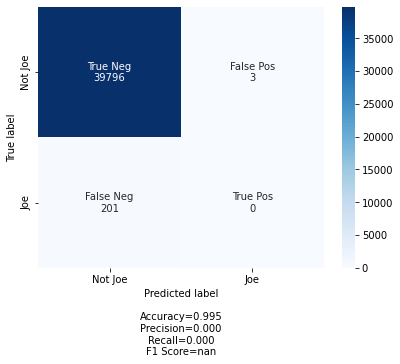

In [111]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
class_names = ["Not Joe", "Joe"]
make_confusion_matrix(y_valid, val_preds, group_names=group_names, categories=class_names, percent=False)

This results confirms demonstrates a persistent problem when dealing with imbalanced class datasets. The extremely high accuracy is not reflected in the other 3 metrics.

Record scores into `results_df` table using the `save_results` function

In [42]:
def save_results(model, model_name, X_train=X_train, X_valid=X_valid, 
                                     y_train=y_train, y_valid= y_valid, thresh = None):
    
    #make predictions for train and validation data
    
    #Predictions if using threshold
    
    if thresh:
        train_probs = model.predict_proba(X_train)[:, 1]
        valid_probs = model.predict_proba(X_valid)[:, 1]
        train_preds = np.where(train_probs>=thresh, 1, 0)
        valid_preds = np.where(valid_probs>=thresh, 1, 0)
        
    else:
        train_preds = model.predict(X_train)
        valid_preds = model.predict(X_valid)
    
    train_results = []
    valid_results = []
    
    #iterate over the four metrics and produce their training and validation scores
    for metric in [accuracy_score, precision_score, recall_score, f1_score]:
        train_results.append(metric(y_train, train_preds).round(4))
        valid_results.append(metric(y_valid, valid_preds).round(4))
        
    #save results into results_df
    
    results_df.loc[model_name+"_train", :] = train_results
    results_df.loc[model_name+"_valid", :] = valid_results

In [43]:
save_results(lr, "Logistic_Regression")

In [44]:
results_df

,accuracy,precision,recall,f1
Logistic_Regression_train,0.9968,0.9355,0.3867,0.5472
Logistic_Regression_valid,0.9966,0.881,0.37,0.5211


The recall score is extremely poor and indicates that our model fails to flag almost two-thirds of joe sessions. To see if we can improve the recall score I'm going to derive the optimal probalitity threshold for the predictions.

The `roc_curve_thresh` function:
    
    - Plots the roc curve
    - Prints the optimal threshold, G-Mean, and AUC score.
    - Returns the optimal threshold for use in future modeling.

In [113]:
val_probs = lr.predict_proba(X_valid)[:, 1]

In [114]:
def roc_curve_thresh(y_test, probs):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    auc_score = roc_auc_score(y_test, probs)
    # calculate the g-mean for each threshold
    gmean = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmean)
    print('Best Threshold={}, G-Mean={}, AUC={}'.format(thresholds[ix].round(4),
                                                        gmean[ix].round(4),
                                                         auc_score.round(4)))
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    return thresholds[ix]

Best Threshold=0.0013, G-Mean=0.96, AUC=0.967


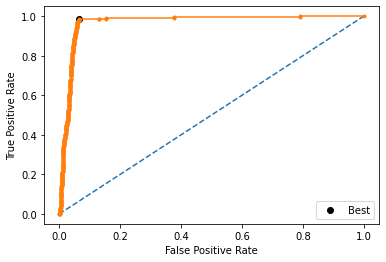

In [115]:
opt_thresh = roc_curve_thresh(y_valid, val_probs)

This function outputs predictions based on a desired probability threshold.

In [116]:
def thresh_predictor(probs, thresh):
    return np.where(probs>=thresh, 1, 0)

In [117]:
#Make predictions based on 
thresh_preds = thresh_predictor(val_probs, opt_thresh)

Visualize confusion matrix

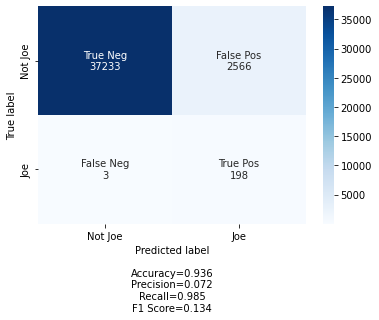

In [118]:

make_confusion_matrix(y_valid, thresh_preds, group_names=group_names, categories=class_names, percent=False)

We managed to produce a perfect recall score (to be expected) using a less strict threshold, however it came at the expense of our precision score. The low precision score indicates that not even one-fifth of our joe predictions are correct.

Save results

In [121]:
# save_results(lr, "Logistic_Regression_opt_thresh", thresh=opt_thresh)

In [120]:
results_df

,accuracy,precision,recall,f1


The imbalanced class necessitates the use of data modification techniques. The two methods I'll be using are reweighting the classes and SMOTE under-sampling.

This next model is essentially a weighted logistic regression model, in which I tell the model weight the smaller class.

In [53]:
lr_cw = LogisticRegression(max_iter= 300, class_weight=class_weights, random_state=1)
lr_cw.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.5025125628140703, 1: 100.0},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=300, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=1, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [54]:
score_print(lr_cw)

Training score is 0.9864 and validation score is 0.987


Weighting the class unfortunately produces scores below the null accuracy.

Now let's see how it peforms based on the other metrics.

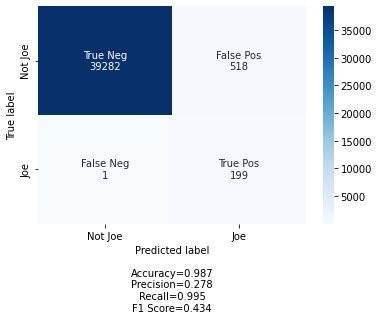

In [55]:
#Predict validation set
val_preds = lr_cw.predict(X_valid)

#Confusion matrix
make_confusion_matrix(y_valid, val_preds, group_names=group_names, categories=class_names, percent=False)



Using weighted classes produces a near perfect recall score and a poor precision score despite an improvement. The F1 score did see improvement but remains far from satisfactory.

Save results

In [56]:
save_results(lr_cw, "Logistic_Regression_weight_class")
results_df

,accuracy,precision,recall,f1
Logistic_Regression_train,0.9968,0.9355,0.3867,0.5472
Logistic_Regression_valid,0.9966,0.881,0.37,0.5211
Logistic_Regression_opt_thresh_train,0.9759,0.1719,1.0,0.2933
Logistic_Regression_opt_thresh_valid,0.9776,0.1826,1.0,0.3089
Logistic_Regression_weight_class_train,0.9864,0.2682,1.0,0.423
Logistic_Regression_weight_class_valid,0.987,0.2775,0.995,0.434


Calculate metrics using optimal threshold

Best Threshold=0.4688, G-Mean=0.9932, AUC=0.9963


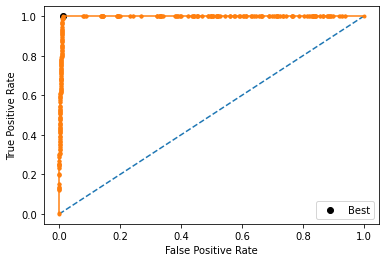

In [57]:
val_probs = lr_cw.predict_proba(X_valid)[:, 1]
opt_thresh = roc_curve_thresh(y_valid, val_probs)

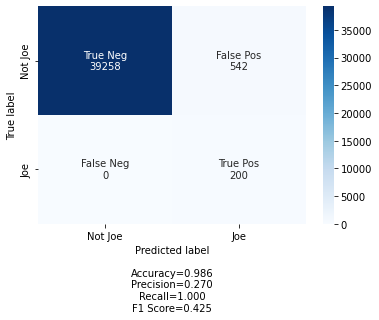

In [58]:
thresh_preds = thresh_predictor(val_probs, thresh=opt_thresh)
make_confusion_matrix(y_valid, thresh_preds,group_names=group_names, categories=class_names, percent=False)

Using an optimized threshold yields a slight decrease in our precision score.

Save results

In [59]:
save_results(lr_cw, "Logistic_Regression_class_weights_opt_thresh",thresh=opt_thresh)
results_df

,accuracy,precision,recall,f1
Logistic_Regression_train,0.9968,0.9355,0.3867,0.5472
Logistic_Regression_valid,0.9966,0.881,0.37,0.5211
Logistic_Regression_opt_thresh_train,0.9759,0.1719,1.0,0.2933
Logistic_Regression_opt_thresh_valid,0.9776,0.1826,1.0,0.3089
Logistic_Regression_weight_class_train,0.9864,0.2682,1.0,0.423
Logistic_Regression_weight_class_valid,0.987,0.2775,0.995,0.434
Logistic_Regression_class_weights_opt_thresh_train,0.9859,0.262,1.0,0.4152
Logistic_Regression_class_weights_opt_thresh_valid,0.9864,0.2695,1.0,0.4246


For the resampling section, I combine oversampling with undersampling.

In [110]:
#Intialize oversampling tool
over = SMOTE(sampling_strategy=.1, random_state=1)
#Intialize undersampling tool
under = RandomUnderSampler(sampling_strategy=.5, random_state=1)

#Construct resampling pipeline
imb_steps = [("over", over), ("under", under)]
imb_pipe = IM_Pipeline(steps=imb_steps)

Resample the training data

In [111]:
X_train_rs, y_train_rs = imb_pipe.fit_resample(X_train, y_train)

/Users/georgemcintire/projects/job_assignments/toptal/George-McIntire-2/assignment_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/georgemcintire/projects/job_assignments/toptal/George-McIntire-2/assignment_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [112]:
X_train_rs.shape

(35820, 83)

In [114]:
pd.value_counts(y_train_rs, normalize=True)

0    0.666667
1    0.333333
dtype: float64

Due to resampling, the training data is about 20% of each original size and the null accuracy is now 66.67%

Now repeat the modeling process with the resampled data

Train a logisitic regression model

In [115]:
lr_rs = LogisticRegression(max_iter=300, random_state=1)
lr_rs.fit(X_train_rs, y_train_rs)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [116]:
train_score = lr_rs.score(X_train_rs, y_train_rs).round(4)
valid_score = lr_rs.score(X_valid, y_valid).round(4)
print(f"Training Score = {train_score}, Validation Score = {valid_score}")

Training Score = 0.9901, Validation Score = 0.9856


The resampled training data does not produce accuracy scores higher than the null accuracy

Let's see how well this technique does with other metrics

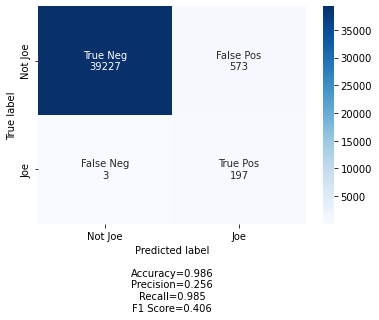

In [117]:
val_preds = lr_rs.predict(X_valid)

make_confusion_matrix(y_valid, val_preds, group_names=group_names, categories=class_names, percent=False)

Resampling does produce a near perfect recall score but fails to make significant improvements in the precision and f1 scores.

In [118]:
save_results(lr_rs, "Logistic_Regression_resampled", X_train=X_train_rs, y_train=y_train_rs)
results_df

,accuracy,precision,recall,f1
Logistic_Regression_train,0.9968,0.9355,0.3867,0.5472
Logistic_Regression_valid,0.9966,0.881,0.37,0.5211
Logistic_Regression_opt_thresh_train,0.9759,0.1719,1.0,0.2933
Logistic_Regression_opt_thresh_valid,0.9776,0.1826,1.0,0.3089
Logistic_Regression_weight_class_train,0.9864,0.2682,1.0,0.423
Logistic_Regression_weight_class_valid,0.987,0.2775,0.995,0.434
Logistic_Regression_class_weights_opt_thresh_train,0.9859,0.262,1.0,0.4152
Logistic_Regression_class_weights_opt_thresh_valid,0.9864,0.2695,1.0,0.4246
Logistic_Regression_resampled_train,0.9901,0.9711,1.0,0.9854
Logistic_Regression_resampled_valid,0.9856,0.2558,0.985,0.4062


The logistic regression resampled model is the first one to demonstrate significant overfitting as shown by the gulf between the training and validation precision and f1 scores.

Best Threshold=0.2896, G-Mean=0.9908, AUC=0.9964


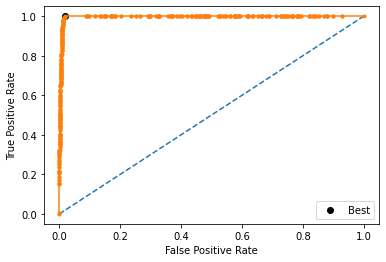

In [119]:
val_probs = lr_rs.predict_proba(X_valid)[:, 1]
opt_thresh = roc_curve_thresh(y_valid, val_probs)

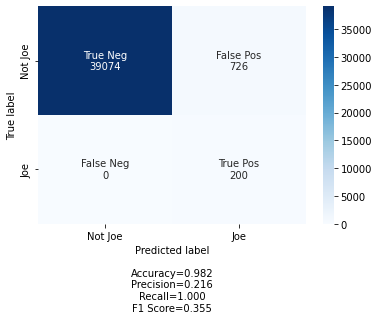

In [120]:
thresh_preds = thresh_predictor(val_probs, thresh=opt_thresh)
make_confusion_matrix(y_valid, thresh_preds,group_names=group_names, categories=class_names, percent=False)

Using an optimized threshold only decreases our precision and f1 scores.

In [121]:
save_results(lr_rs, "Logistic_Regression_resampled_opt_thresh", 
             X_train=X_train_rs, y_train=y_train_rs, thresh=opt_thresh)
results_df

,accuracy,precision,recall,f1
Logistic_Regression_train,0.9968,0.9355,0.3867,0.5472
Logistic_Regression_valid,0.9966,0.881,0.37,0.5211
Logistic_Regression_opt_thresh_train,0.9759,0.1719,1.0,0.2933
Logistic_Regression_opt_thresh_valid,0.9776,0.1826,1.0,0.3089
Logistic_Regression_weight_class_train,0.9864,0.2682,1.0,0.423
Logistic_Regression_weight_class_valid,0.987,0.2775,0.995,0.434
Logistic_Regression_class_weights_opt_thresh_train,0.9859,0.262,1.0,0.4152
Logistic_Regression_class_weights_opt_thresh_valid,0.9864,0.2695,1.0,0.4246
Logistic_Regression_resampled_train,0.9901,0.9711,1.0,0.9854
Logistic_Regression_resampled_valid,0.9856,0.2558,0.985,0.4062


### Random Forest.

In this section I opt for a higher performing modeling to see make significant improvements upon on my modeling.

Similar to the Logistic Regression section, I'll also be optimizing the probability threshold and sampling to deal with the imbalanced class. What's different in this section is the use of parameter tuning to determine the best Random Forest model.

Train a baseline Random Forest model using the default settings.

In [122]:

rf = RandomForestClassifier(random_state=1) #default n estimators = 100
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [123]:
score_print(rf)

Training score is 1.0 and validation score is 0.9968


Random Forest produces a perfect training score but virtually the same validation score as Logistic Regression.

Cross validate to check for overfitting

In [124]:
kf = KFold(n_splits=5)
rf_cv = cross_val_score(rf, X_train, y_train, cv=kf)
rf_cv.mean()

0.9966583333333332

The cross validated accuracy is slightly lower than that of our validation score.

Evaluate Random Forest using other metrics

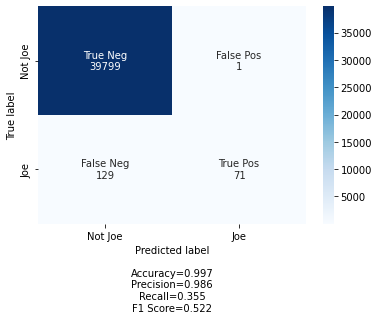

In [125]:
val_preds = rf.predict(X_valid)

make_confusion_matrix(y_valid, val_preds, group_names=group_names, categories=class_names, percent=False)

The Random Forest baseline model produces a very similar result to the baseline Logistic Regression model.

Save results

In [126]:
save_results(lr, "Random_Forest")
results_df

,accuracy,precision,recall,f1
Logistic_Regression_train,0.9968,0.9355,0.3867,0.5472
Logistic_Regression_valid,0.9966,0.881,0.37,0.5211
Logistic_Regression_opt_thresh_train,0.9759,0.1719,1.0,0.2933
Logistic_Regression_opt_thresh_valid,0.9776,0.1826,1.0,0.3089
Logistic_Regression_weight_class_train,0.9864,0.2682,1.0,0.423
Logistic_Regression_weight_class_valid,0.987,0.2775,0.995,0.434
Logistic_Regression_class_weights_opt_thresh_train,0.9859,0.262,1.0,0.4152
Logistic_Regression_class_weights_opt_thresh_valid,0.9864,0.2695,1.0,0.4246
Logistic_Regression_resampled_train,0.9901,0.9711,1.0,0.9854
Logistic_Regression_resampled_valid,0.9856,0.2558,0.985,0.4062


Optimize threshold

Best Threshold=0.02, G-Mean=0.9781, AUC=0.9961


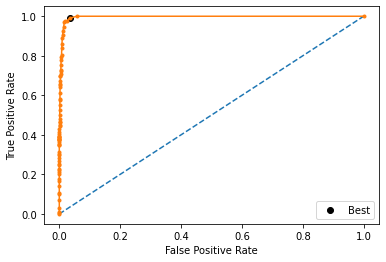

In [127]:
val_probs = rf.predict_proba(X_valid)[:, 1]
opt_thresh = roc_curve_thresh(y_valid, val_probs)

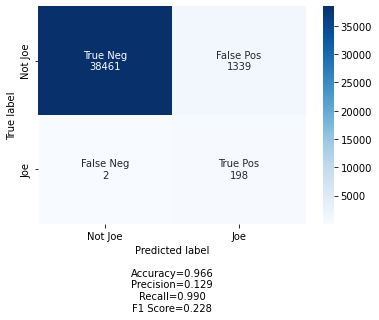

In [128]:
thresh_preds = thresh_predictor(val_probs, thresh=opt_thresh)
make_confusion_matrix(y_valid, thresh_preds,group_names=group_names, categories=class_names, percent=False)

As we saw with Logistic Regression, Random Forest predictions subject to an optimized threshold produce a near perfect recall but atrocious precision and f1 scores.

In [129]:
save_results(rf,"Random_Forest_opt_thresh", thresh=opt_thresh)
results_df

,accuracy,precision,recall,f1
Logistic_Regression_train,0.9968,0.9355,0.3867,0.5472
Logistic_Regression_valid,0.9966,0.881,0.37,0.5211
Logistic_Regression_opt_thresh_train,0.9759,0.1719,1.0,0.2933
Logistic_Regression_opt_thresh_valid,0.9776,0.1826,1.0,0.3089
Logistic_Regression_weight_class_train,0.9864,0.2682,1.0,0.423
Logistic_Regression_weight_class_valid,0.987,0.2775,0.995,0.434
Logistic_Regression_class_weights_opt_thresh_train,0.9859,0.262,1.0,0.4152
Logistic_Regression_class_weights_opt_thresh_valid,0.9864,0.2695,1.0,0.4246
Logistic_Regression_resampled_train,0.9901,0.9711,1.0,0.9854
Logistic_Regression_resampled_valid,0.9856,0.2558,0.985,0.4062


These initial Random Forest results are disappointing so it is my hope that we parameter-tuning can produce better metrics.

Before I move onto parameter tuning let's see what are the best features according to the Random Forest model

In [130]:
rf_fi = pd.Series(index=X_train.columns, data = rf.feature_importances_)

The top 20 most important features according to Random Forest

In [131]:
rf_fi.nlargest(20)

country_Canada          0.114862
site_slack_com          0.083094
site_youtube_com        0.080193
site_vk_com             0.079566
site_lenta_ru           0.078730
site_mail_google_com    0.076482
country_Singapore       0.060163
russia_software_RU      0.056725
hour_19                 0.021729
hour_20                 0.018540
os_Ubuntu               0.017889
country_France          0.015569
hour_10                 0.015310
browser_Firefox         0.013795
site_wikimedia_org      0.013552
site_skype_com          0.013502
site_facebook_com       0.013218
site_doubleclick_net    0.012880
site_yahoo_com          0.011907
hour_11                 0.011098
dtype: float64

In [132]:
#intialize the parameter grid
n_estimators = np.arange(150, 550, 50)
param_grid = dict(n_estimators=n_estimators)

# Build the grid search, cross validate 5 times and optimize using the f1 score

grid = GridSearchCV(estimator=RandomForestClassifier(random_state=1), 
                    param_grid=param_grid, cv = 5, scoring="f1", verbose=5)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] n_estimators=150 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=150, score=0.548, total=   6.0s
[CV] n_estimators=150 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] .................... n_estimators=150, score=0.436, total=   6.0s
[CV] n_estimators=150 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s


[CV] .................... n_estimators=150, score=0.568, total=   5.9s
[CV] n_estimators=150 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.0s remaining:    0.0s


[CV] .................... n_estimators=150, score=0.512, total=   6.0s
[CV] n_estimators=150 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.0s remaining:    0.0s


[CV] .................... n_estimators=150, score=0.491, total=   6.8s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.548, total=   7.7s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.426, total=   8.2s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.576, total=   8.2s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.503, total=   7.9s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.479, total=   8.1s
[CV] n_estimators=250 ................................................
[CV] .................... n_estimators=250, score=0.539, total=  10.2s
[CV] n_estimators=250 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  9.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                   

In [133]:
print("The best parameters = {} and best score = {}".format(grid.best_params_, grid.best_score_.round(4)))

The best parameters = {'n_estimators': 400} and best score = 0.5132


Save best model

In [134]:
rf_gs = grid.best_estimator_

Get training and validation accuracy scores

In [135]:
score_print(rf_gs)

Training score is 1.0 and validation score is 0.9968


The grid search Random Forest model does not produce a higher validation accuracy than its baseline counterpart

Evaluate using other metrics

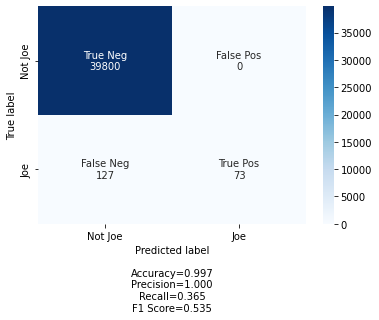

In [136]:
val_preds = rf_gs.predict(X_valid)

make_confusion_matrix(y_valid, val_preds, group_names=group_names, categories=class_names, percent=False)

Save results

In [137]:
save_results(rf_gs,"Random_Forest_GS")
results_df

,accuracy,precision,recall,f1
Logistic_Regression_train,0.9968,0.9355,0.3867,0.5472
Logistic_Regression_valid,0.9966,0.881,0.37,0.5211
Logistic_Regression_opt_thresh_train,0.9759,0.1719,1.0,0.2933
Logistic_Regression_opt_thresh_valid,0.9776,0.1826,1.0,0.3089
Logistic_Regression_weight_class_train,0.9864,0.2682,1.0,0.423
Logistic_Regression_weight_class_valid,0.987,0.2775,0.995,0.434
Logistic_Regression_class_weights_opt_thresh_train,0.9859,0.262,1.0,0.4152
Logistic_Regression_class_weights_opt_thresh_valid,0.9864,0.2695,1.0,0.4246
Logistic_Regression_resampled_train,0.9901,0.9711,1.0,0.9854
Logistic_Regression_resampled_valid,0.9856,0.2558,0.985,0.4062


Optimize Threshold

Best Threshold=0.03, G-Mean=0.989, AUC=0.9965


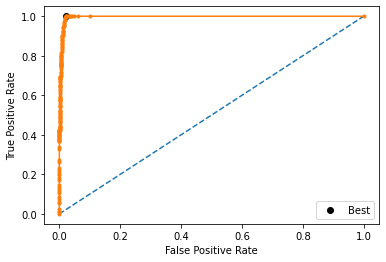

In [138]:
val_probs = rf_gs.predict_proba(X_valid)[:, 1]
opt_thresh = roc_curve_thresh(y_valid, val_probs)

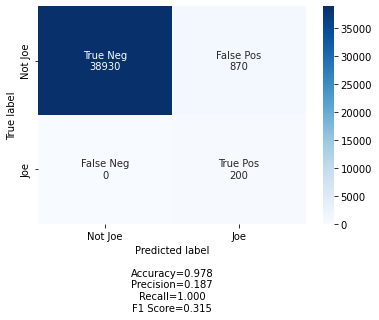

In [139]:
thresh_preds = thresh_predictor(val_probs, thresh=opt_thresh)
make_confusion_matrix(y_valid, thresh_preds,group_names=group_names, categories=class_names, percent=False)

We're seeing familiar results here, the Random Forest with an optimized threshold produces a perfect recall score at the expense of its precision and f1 scores.

Save results

In [140]:
save_results(rf_gs,"Random_Forest_GS_opt_thresh", thresh=opt_thresh)
results_df

,accuracy,precision,recall,f1
Logistic_Regression_train,0.9968,0.9355,0.3867,0.5472
Logistic_Regression_valid,0.9966,0.881,0.37,0.5211
Logistic_Regression_opt_thresh_train,0.9759,0.1719,1.0,0.2933
Logistic_Regression_opt_thresh_valid,0.9776,0.1826,1.0,0.3089
Logistic_Regression_weight_class_train,0.9864,0.2682,1.0,0.423
Logistic_Regression_weight_class_valid,0.987,0.2775,0.995,0.434
Logistic_Regression_class_weights_opt_thresh_train,0.9859,0.262,1.0,0.4152
Logistic_Regression_class_weights_opt_thresh_valid,0.9864,0.2695,1.0,0.4246
Logistic_Regression_resampled_train,0.9901,0.9711,1.0,0.9854
Logistic_Regression_resampled_valid,0.9856,0.2558,0.985,0.4062


Next step is to employ the resampling techniques

Train Random Forest model on the resampled data

In [141]:
rf_rs = RandomForestClassifier(n_estimators=400, random_state=1)
rf_rs.fit(X_train_rs, y_train_rs)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [142]:
score_print(rf_rs)

Training score is 0.9941 and validation score is 0.9922


Still not surpassing the null accuracy here.

Evaluate using other metrics

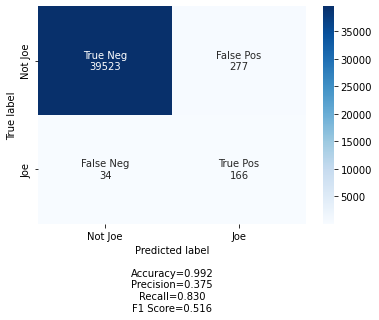

In [143]:
val_preds = rf_rs.predict(X_valid)

make_confusion_matrix(y_valid, val_preds, group_names=group_names, categories=class_names, percent=False)

Resampling the data pushes our F1 score up from the optimized threshold model.

Save results

In [144]:
save_results(rf_rs, "Random_Forest_resampled")

### Deciding on the Best Model.

After an exhaustive modeling process, it appears I've encountered a wall in terms of improving model performance.

None of the models were able to achieve an exceptional f1 score. Some models were able to achieve fantastic recall or precision scores but those high scores always came at the cost of the other.

Using the table, that kept track of all the model performances, to choose the best model, I pick grid searched Random Forest model because it has the highest validation f1 score.

In [146]:
results_df

,accuracy,precision,recall,f1
Logistic_Regression_train,0.9968,0.9355,0.3867,0.5472
Logistic_Regression_valid,0.9966,0.881,0.37,0.5211
Logistic_Regression_opt_thresh_train,0.9759,0.1719,1.0,0.2933
Logistic_Regression_opt_thresh_valid,0.9776,0.1826,1.0,0.3089
Logistic_Regression_weight_class_train,0.9864,0.2682,1.0,0.423
Logistic_Regression_weight_class_valid,0.987,0.2775,0.995,0.434
Logistic_Regression_class_weights_opt_thresh_train,0.9859,0.262,1.0,0.4152
Logistic_Regression_class_weights_opt_thresh_valid,0.9864,0.2695,1.0,0.4246
Logistic_Regression_resampled_train,0.9901,0.9711,1.0,0.9854
Logistic_Regression_resampled_valid,0.9856,0.2558,0.985,0.4062


In [148]:
#Save best model
joblib.dump(rf_gs, "../model/Random_Forest_model.pkl")

['../model/Random_Forest_model.pkl']

Throughout the course of the modeling it's become clear choosing the right probability threshold is extremely important. That's why I feel it is necessary to include the following chart that shows the relationship between probability threshold and the precision and recall scores.

In [152]:
#make validation predictions
val_preds = rf_gs.predict_proba(X_valid)[:, 1]

In [159]:
precisions, recalls, thresholds = precision_recall_curve(y_valid, val_preds)

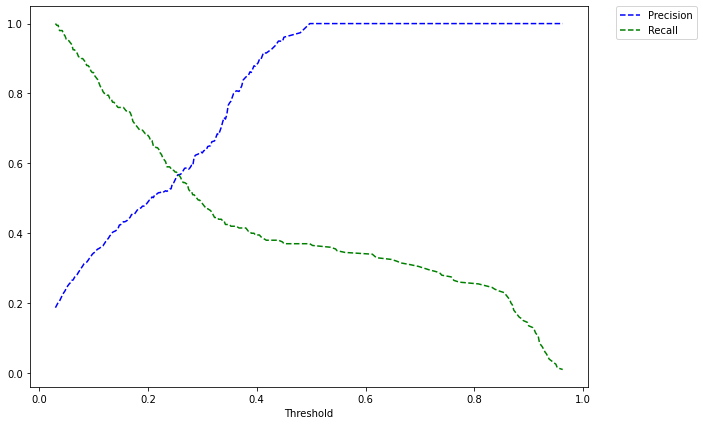

In [162]:
plt.figure(figsize = (10, 7))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

I advise the stakeholders to consult this graph in order to choose the optimal threshold that strikes the right balance between false negatives and false positives.